Homework 3.1 Preparing report on SMS spam filtering analysis
===
<b>STEP 1: Loading the data</b>

To build the Naive Bayes classifier, we used data adapted from the SMS Spam Collection at http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/

In [1]:
setwd("C:/Users/Allie/Desktop/R")

In [2]:
# Loading the csv file
sms_raw <- read.csv("sms_spam.csv", stringsAsFactors = FALSE)

<b>STEP 2: Exploring and preparing the data</b>

The data frame includes 5,559 SMS messages. The type element is currently a char vector. Since this is a categorical variable, we need to convert it into a factor:

In [3]:
str(sms_raw)

'data.frame':	5559 obs. of  2 variables:
 $ type: chr  "ham" "ham" "ham" "spam" ...
 $ text: chr  "Hope you are having a good week. Just checking in" "K..give back my thanks." "Am also doing in cbe only. But have to pay." "complimentary 4 STAR Ibiza Holiday or Â£10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out"| __truncated__ ...


In [4]:
# Converting spam/ham to factor
sms_raw$type <- factor(sms_raw$type)

Futher preparation of the data frame includes cutting the messages into single words, removing numbers, punctuation, and extra spaces. We also want same words with different capitalization to be counted as instances of one word, therefore we need to convert all words into their lowercase versions.
The next data prep step includes removal of the *stop words* - filling words such as *and, or, but*.
The final step of the data transformation is *stemming* - process of reducing words to their root form. Example: *call, calling, called.*
To perform the above transformation, we need to download and install <b>*tm*</b> package.

In [5]:
# Building a corpus using the text mining (tm) package
library(tm)
sms_corpus <- VCorpus(VectorSource(sms_raw$text))

Loading required package: NLP


In [6]:
sms_dtm <- DocumentTermMatrix(sms_corpus, control = list(
  tolower = TRUE,
  removeNumbers = TRUE,
  stopwords = TRUE,
  removePunctuation = TRUE,
  stemming = TRUE
))

In [7]:
sms_dtm

<<DocumentTermMatrix (documents: 5559, terms: 6965)>>
Non-/sparse entries: 43231/38675204
Sparsity           : 100%
Maximal term length: 40
Weighting          : term frequency (tf)

In [8]:
# Creating training and test datasets
sms_dtm_train <- sms_dtm[1:4169, ]
sms_dtm_test  <- sms_dtm[4170:5559, ]

In [9]:
# Saving the labels
sms_train_labels <- sms_raw[1:4169, ]$type
sms_test_labels  <- sms_raw[4170:5559, ]$type

In [10]:
# Checking that the proportion of spam is similar
prop.table(table(sms_train_labels))
prop.table(table(sms_test_labels))

sms_train_labels
      ham      spam 
0.8647158 0.1352842 

sms_test_labels
      ham      spam 
0.8683453 0.1316547 

A <b>*word cloud*</b> is a way to visually depict the frequency at which words appear in text data. The cloud is composed of words scattered somewhat randomly around the figure. Words appearing more often in the text are shown in a *larger* font, while less common terms are shown in *smaller* fonts. To perform that, we need to install and load the *wordcloud* package:

In [20]:
library(wordcloud)
# Subseting the training data into spam and ham groups
spam <- subset(sms_raw, type == "spam")
ham  <- subset(sms_raw, type == "ham")

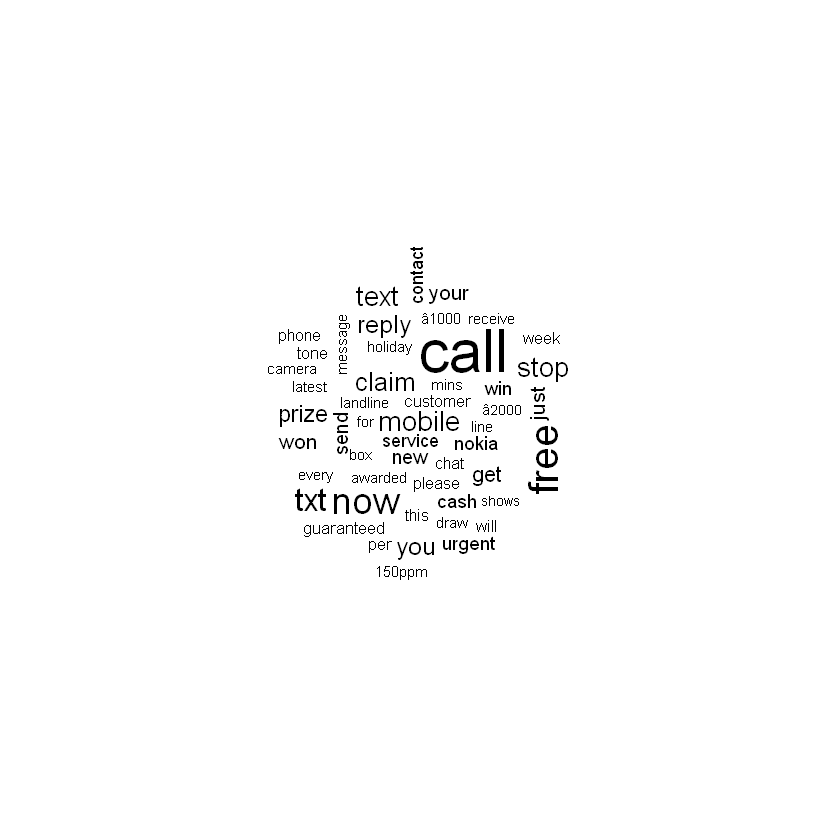

In [12]:
# Displaying frequent words in spam with min count of 50
wordcloud(spam$text, max.words = 50, scale = c(3, 0.5))

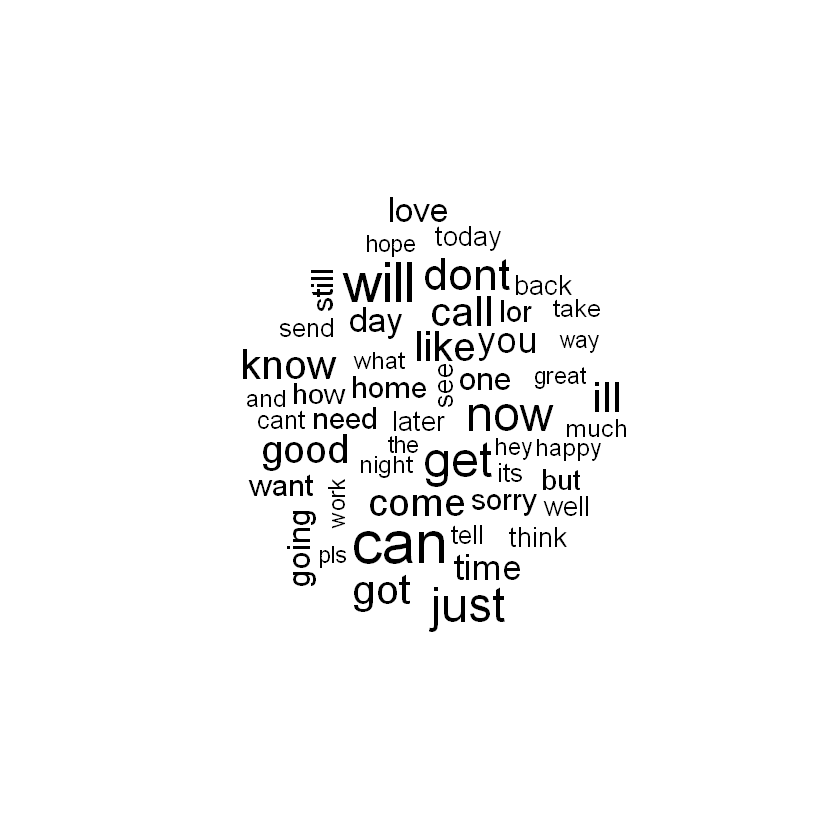

In [13]:
# In ham
wordcloud(ham$text, max.words = 50, scale = c(3, 0.5))

The final step in the data preparation process is to transform the sparse matrix into a data structure that can be used to train a Naive Bayes classifier. It is unlikely that all of the feautures are useful for classification. To reduce the number of features, we will eliminate any word that appear in less than five SMS messages, or in less than about 0.1 percent of the records in the training data.

In [14]:
# Removing sparse terms
sms_dtm_freq_train <- removeSparseTerms(sms_dtm_train, 0.999)

In [15]:
# Saving frequently-appearing terms to a character vector
sms_freq_words <- findFreqTerms(sms_dtm_train, 5)

In [16]:
# Creating Document Term Matrix with only the frequent terms
sms_dtm_freq_train <- sms_dtm_train[ , sms_freq_words]
sms_dtm_freq_test <- sms_dtm_test[ , sms_freq_words]

In [17]:
# Converting counts to a factor
convert_counts <- function(x) {
  x <- ifelse(x > 0, "Yes", "No")
}

# Appling convert_counts() to columns of train/test data
sms_train <- apply(sms_dtm_freq_train, MARGIN = 2, convert_counts)
sms_test  <- apply(sms_dtm_freq_test, MARGIN = 2, convert_counts)

<b>STEP 3: Training a model on the data</b>

We use the package *e1071* for building the Classifier:

In [18]:
library(e1071)
sms_classifier <- naiveBayes(sms_train, sms_train_labels)

<b>STEP 4: Evaluating model performance</b>

Using CrossTable() function in *gmodels* package, we are printing out the confusion matrix as the part of the model evaluation.

In [19]:
sms_test_pred <- predict(sms_classifier, sms_test)

In [21]:
library(gmodels)
CrossTable(sms_test_pred, sms_test_labels,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1202 |        30 |      1232 | 
             |     0.996 |     0.164 |           | 
-------------|-----------|-----------|-----------|
        spam |         5 |       153 |       158 | 
             |     0.004 |     0.836 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 


The Classifier perfomed fairly well with 35 insances being missclasified. The Accuracy Rate is 97%.

<b>STEP 5: Improving model performance using Laplace smoothing</b>:

Typically, the Laplace estimator is set to 1, which ensures that each class-feature combination is found in the data at least once.

In [22]:
sms_classifier2 <- naiveBayes(sms_train, sms_train_labels, laplace = 1)
sms_test_pred2 <- predict(sms_classifier2, sms_test)
CrossTable(sms_test_pred2, sms_test_labels,
           prop.chisq = FALSE, prop.t = FALSE, prop.r = FALSE,
           dnn = c('predicted', 'actual'))


 
   Cell Contents
|-------------------------|
|                       N |
|           N / Col Total |
|-------------------------|

 
Total Observations in Table:  1390 

 
             | actual 
   predicted |       ham |      spam | Row Total | 
-------------|-----------|-----------|-----------|
         ham |      1202 |        29 |      1231 | 
             |     0.996 |     0.158 |           | 
-------------|-----------|-----------|-----------|
        spam |         5 |       154 |       159 | 
             |     0.004 |     0.842 |           | 
-------------|-----------|-----------|-----------|
Column Total |      1207 |       183 |      1390 | 
             |     0.868 |     0.132 |           | 
-------------|-----------|-----------|-----------|

 


In our case, using laplace smoothing did not significantly improve the model Accuracy.